# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
from sklearn.metrics import accuracy_score


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
# First, let#s search for NaNs in both data sets
print('The number of null values in User_item_interactions (df) is\n'+ f' \n{df.isnull().sum()}')
print('\nThe number of null values in articles-community (df_content) is\n'+ f' \n{df_content.isnull().sum()}')

The number of null values in User_item_interactions (df) is
 
article_id     0
title          0
email         17
dtype: int64

The number of null values in articles-community (df_content) is
 
doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


In [5]:
print (f'The following articles have no emails associated to it \n {df[df.email.isnull()]}')

The following articles have no emails associated to it 
        article_id                                              title email
25131      1016.0  why you should master r (even if it might even...   NaN
29758      1393.0                       the nurse assignment problem   NaN
29759        20.0  working interactively with rstudio and noteboo...   NaN
29760      1174.0      breast cancer wisconsin (diagnostic) data set   NaN
29761        62.0  data visualization: the importance of excludin...   NaN
35264       224.0                   using apply, sapply, lapply in r   NaN
35276       961.0                     beyond parallelize and collect   NaN
35277       268.0                      sector correlations shiny app   NaN
35278       268.0                      sector correlations shiny app   NaN
35279       268.0                      sector correlations shiny app   NaN
35280       268.0                      sector correlations shiny app   NaN
35281       415.0  using machine learning t

In [6]:
user_interaction_count = df['email'].value_counts(dropna = False)

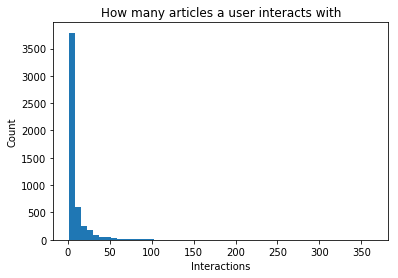

In [7]:
plt.hist(user_interaction_count, bins = 50)
plt.title('How many articles a user interacts with')
plt.xlabel('Interactions')
plt.ylabel('Count')
plt.show()

In [8]:
#Description about the histogram
user_interaction_count.describe()

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [9]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(user_interaction_count) # 50% of individuals interact with ____ number of articles or fewer.
print(f'50% of individuals interact with {median_val} number of articles or fewer')
max_views_by_user = np.max(user_interaction_count) # The maximum number of user-article interactions by any 1 user is ______.
print(f'\nThe maximum number of user-article interactions by any 1 user is {max_views_by_user}')

50% of individuals interact with 3.0 number of articles or fewer

The maximum number of user-article interactions by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [10]:
# Find and explore duplicate articles

print('Following articles are duplicated')
df_content[df_content["article_id"].duplicated()]

Following articles are duplicated


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [11]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset = ["article_id"])

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [12]:
len(df)

45993

In [13]:
unique_articles = df['article_id'].nunique() # The number of unique articles that have at least one interaction
print(f'\n The number of unique articles that have at least one interaction is {unique_articles}')
total_articles = len(df_content['article_id']) # The number of unique articles on the IBM platform
print(f'\n The number of unique articles on the IBM platform is {total_articles}')
unique_users = df['email'].nunique() # The number of unique users
print(f'\n The number of unique users is {unique_users}')
user_article_interactions = len(df)# The number of user-article interactions
print(f'\n The number of user-article interactions is {user_article_interactions}')


 The number of unique articles that have at least one interaction is 714

 The number of unique articles on the IBM platform is 1051

 The number of unique users is 5148

 The number of user-article interactions is 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
df_aux = df['article_id'].value_counts().rename_axis('Article').reset_index(name='Times Read')
df_aux.head()
#df_aux.loc[0][1]

#https://stackoverflow.com/questions/47136436/python-pandas-convert-value-counts-output-to-dataframe

,Article,Times Read
0,1429.0,937
1,1330.0,927
2,1431.0,671
3,1427.0,643
4,1364.0,627


In [15]:
df_aux.loc[0][0]

1429.0

In [16]:
most_viewed_article_id = str(df_aux.loc[0][0]) # The most viewed article in the dataset as a string with one value following the decimal 
print(f'\nThe most viewed article in the dataset is {most_viewed_article_id}')
max_views = df_aux.loc[0][1] # The most viewed article in the dataset was viewed how many times?
print(f'\nThe most viewed article in the dataset was viewed  {max_views} times')


The most viewed article in the dataset is 1429.0

The most viewed article in the dataset was viewed  937.0 times


In [17]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
#testing for the function top articles
list(df['title'].value_counts().head(5).index)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [20]:
#testing for top article id
list(df['article_id'].value_counts().head(5).index)

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df['title'].value_counts().head(n).index)
  
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles=list(df['article_id'].value_counts().head(n).index)
 
    return top_articles # Return the top article ids

In [22]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [23]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [24]:
user_item = df.groupby(["user_id", "article_id"])["title"].apply(lambda x :1).unstack()
user_item.fillna(0, inplace=True)
user_item.head(5)
# looks good, let´s try it on the function below

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    user_item =  df.groupby(["user_id", "article_id"])["title"].apply(lambda x :1).unstack()
    
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [26]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [27]:
#cell for testing for the function
user_id=1
len(user_item)

#sim_users = np.dot(user_item.loc[user_id].user_item[i])
sim_users = {}
sim_users[1] = np.dot(user_item.loc[user_id], user_item.loc[1])
sim_users[2] = np.dot(user_item.loc[user_id], user_item.loc[2])
sim_users[3] = np.dot(user_item.loc[user_id], user_item.loc[3])

sim_users = sorted(sim_users.items(), key= lambda item:item[1], reverse = True)
id_list =[]
for sim_user in sim_users:
    id_list.append(sim_user[0])
#id_list is a list

try:
    id_list.remove(5)
    similar_users = id_list
    
except:
    print ('not found')
    similar_users = id_list

similar_users

not found


[1, 3, 2]

In [28]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    sim_users = {}
    n = len(user_item)
    
    for i in range(1,n): # label "0" is not in index error, starting from 1
        sim_users[i] = np.dot(user_item.loc[user_id],user_item.loc[i])

    # sort by similarity
    sim_users = sorted(sim_users.items(), key= lambda item:item[1], reverse = True) # reverse= true for descending order
    
    #https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    #https://www.programiz.com/python-programming/methods/built-in/sorted

    # create list of just the ids
    
    id_list =[]
    for sim_user in sim_users:
        id_list.append(sim_user[0])   
   
    # remove the own user's id
    try:
        id_list.remove(user_id)
        most_similar_users = id_list
    
    except:
        print ('not found')
        most_similar_users = id_list
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [29]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [43]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique().tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # for the length of the loop
    n = len(user_item.loc[user_id])
    #creating article_ids
    article_ids = []
    #looping through values
    
    for i in range (n):
        if int(user_item.loc[user_id].values[i]):
            article_ids.append(str(user_item.loc[user_id].index[i]))
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    #get similar users
    most_similar_users = find_similar_users(user_id)

    #create recs not seen by user
    recs= []
    user_article_ids = set(get_user_articles(user_id)[0])
    for neighbor_id in most_similar_users:
        neighbor_article_ids = set(get_user_articles(neighbor_id)[0])
        recs.extend(list(set(neighbor_article_ids) - set(user_article_ids)))# difference between seen and not seen
        
        if len(recs) > m:
            break
            
    # code from above got from mentor in review 

    #returning the number of recommendations we want
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [44]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['timeseries data analysis of iot events by using jupyter notebook',
 'data science for real-time streaming analytics',
 'maximize oil company profits',
 'analyzing data by using the sparkling.data library features',
 'using brunel in ipython/jupyter notebooks',
 'easy json loading and social sharing in dsx notebooks',
 'declarative machine learning',
 'the 3 kinds of context: machine learning and the art of the frame',
 'generalization in deep learning',
 'get started with streams designer by following this roadmap']

In [45]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [46]:
user_article = df.groupby(["user_id"])["article_id"].count()
user_article.head(5)


user_id
1    47
2     6
3    82
4    45
5     5
Name: article_id, dtype: int64

In [47]:
#auxiliary cell
n = len(user_item)

neighbor_id = []
for i in range(1,n):
    if i != user_id:
        neighbor_id.append(i)

similarity = []
num_interactions = []
    
#get Similarities (similar as before) 
for i in neighbor_id:
    similarity.append(np.dot(user_item.loc[user_id],user_item.loc[i]))
    #get number of interactions:
    num_interactions.append(user_article.loc[i])
    
    #create DataFrame
    
neighbors_df = pd.DataFrame ({'neighbor_id':neighbor_id, 'similarity':similarity,'num_interactions':num_interactions})

neighbors_df.head()

,neighbor_id,similarity,num_interactions
0,2,2.0,6
1,3,6.0,82
2,4,3.0,45
3,5,0.0,5
4,6,4.0,19


5147

In [84]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    user_article = df.groupby(["user_id"])["article_id"].count()
    n = len(user_item)
    
    # columns of new DataFrame
    
    neighbor_id = []
    
    for i in range(1,n):
        if i != user_id:
            neighbor_id.append(i) 
    
    
    similarity = []
    num_interactions = []
    
    #get Similarities (similar as before) 
    for i in neighbor_id:
        similarity.append(np.dot(user_item.loc[user_id],user_item.loc[i]))
        #get number of interactions:
        num_interactions.append(user_article.loc[i])
    
    #create DataFrame
    
    neighbors_df = pd.DataFrame ({'neighbor_id':neighbor_id, 'similarity':similarity,'num_interactions':num_interactions})
    neighbors_df.sort_values(by=['similarity', 'num_interactions'],inplace=True, ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # running previous function 
    neighbors_df = get_top_sorted_users(user_id)
    #grabbing also the "m" top neighbor users
    top_neigh_ids = neighbors_df[:m]['neighbor_id'].tolist()
    
    recs = []
    
    user_article_ids = set(get_user_articles(user_id)[0])# getting already seen
    top_articles = set(get_top_article_ids(len(neighbors_df))) # getting top articles Ids. 
    
    for neighbor_id in top_neigh_ids:
        neighbor_article_ids = set(get_user_articles(neighbor_id)[0])
        #neighbor_article_ids =set(top_articles)-set(neighbor_article_ids)# I shouldn´t substract!
        neighbor_article_ids =set.intersection (top_articles, neighbor_article_ids)
        recs.extend(list(set(neighbor_article_ids) - set(user_article_ids)))
        if len(recs) > m:
            break

# the above code based on mentor recommendations of first review, added 
#https://www.codingem.com/python-append-vs-extend/


    recs = list(set(recs[:m]))
    rec_names = list(set(df[df["article_id"].isin(recs)]["title"]))
    
     
    return recs, rec_names

In [85]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[]

The top 10 recommendations for user 20 are the following article names:
[]


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [68]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]   # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9]   # Find the 10th most similar user to user 131

In [69]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Using available functions**
If there is a new user, we will encounter the so called "cold start Problem".  This problem is common in recommendation engines, as the question is how to recommend something for a new user from which I don´t have any information of. As we do not know what the user likes, dislikes or can compare it to a similar user, the best way to address this problem would be to recommend the top articles to his user. We can use the function **get_top_article_ids(m)**, being m the number of articles we want to recommend to new users. 

In most cases, the top read articles could be of interest to new users, and when the user reads some of them, we can recommend better articles.

**Another way to approach the cold start problem **

Another way could be using knowledge based or content based recommendation engines.  asking some questions beforehand (like filters on issues on topics) to reccommend the most read articles in those categories.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(i) for i in get_top_article_ids(10)] # Your recommendations here



In [39]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [40]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [41]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [42]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [43]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [44]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

#### On the lesson we saw the problem of having a lots of NaNS in the matrix. This was due to having a user and movie database, but missing a lot of the scores or ranks for the movies. In this case, as we do not have that information, we assumed that the most read are the most popular, and also the information is binary (1 read, 0 not read). We also eliminated at the beggining the 16 rows with missings values. In case we had NaNs, the FUNK SVD approach would have made more sense. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

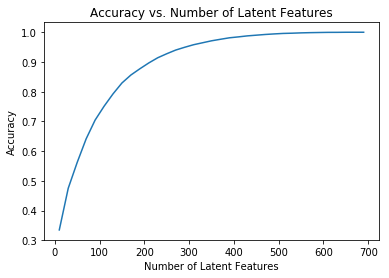

In [45]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [61]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.unique().tolist()
    test_arts = user_item_test.columns.tolist() #list(user_item_train.columns) using this, got problems later
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [62]:
print (f' How many users can we make predictions for in the test set? {np.intersect1d(user_item_test.index, user_item_train.index).size}')
print (f' How many users in the test set are we not able to make predictions for because of the cold start problem? {len(set(user_item_test.index) - set(user_item_train.index))}')
print (f' How many articles can we make predictions for in the test set? {np.intersect1d(user_item_test.columns, user_item_train.columns).size}')
print (f' How many articles in the test set are we not able to make predictions for because of the cold start problem? {len(np.setdiff1d(user_item_test.columns, user_item_train.columns))}')


 How many users can we make predictions for in the test set? 20
 How many users in the test set are we not able to make predictions for because of the cold start problem? 662
 How many articles can we make predictions for in the test set? 574
 How many articles in the test set are we not able to make predictions for because of the cold start problem? 0


In [63]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [64]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [65]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [66]:
# Trying to find subset that can be predicted by SVD
u_test = u_train[user_item_train.index.isin(test_idx), :]
vt_test = vt_train[:, user_item_train.columns.isin(user_item_test.columns)]

#checking the shapes 
print(f'U_Test shape is {u_test.shape} and \n the shape of V_test is {vt_test.shape}')

U_Test shape is (20, 4487) and 
 the shape of V_test is (714, 574)


In [67]:
# the same for test Data 
train_idx = user_item_train.index
sub_user_test = user_item_test.loc[user_item_test.index.isin(train_idx)]


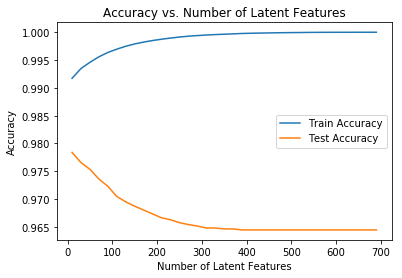

In [68]:
latent_feats = np.arange(10, 700+10, 20)

train_error = []
test_error = []


for k in latent_feats:
    # restructure with k latent features
    s_train_lat_feat, u_train_lat_feat, vt_train_lat_feat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_lat_feat, vt_test_lat_feat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_predic = np.around(np.dot(np.dot(u_train_lat_feat, s_train_lat_feat), vt_train_lat_feat))
    user_item_test_predic = np.around(np.dot(np.dot(u_test_lat_feat, s_train_lat_feat), vt_test_lat_feat))
    
    # compute prediction accuracy
    train_error.append(accuracy_score(user_item_train.values.flatten(), user_item_train_predic.flatten()))
    test_error.append(accuracy_score(sub_user_test.values.flatten(), user_item_test_predic.flatten()))


plt.figure()
plt.plot(latent_feats, train_error, label='Train Accuracy')
plt.plot(latent_feats, test_error, label='Test Accuracy')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.legend()
plt.show()



`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

#####  The model accuracy seems high as in the training set it is almost reaching 100%. In the test set, it also reaches a good accuracy of 96,5%. But this is misleading, as accuracy doesn´t  seem to be the best metric for . The number of users that were common in both sets is only 20, so it´s hard to generalize a model with so few users. Also we have the problem of the data being "sparse" as there are only a couple of values (1s) and most of the values are zero. This also leads to an imbalanced data set. 
#####  With the above results we can estimate how many latent features we can determine to use in the full model set. We use the same method as in k-means clustering, trying to identify the "elbow" where the curve changes slope and we don´t have a significant gain in accuracy. This can be estimated to be between 100 and 200 latent features. Which one to use? it depends on the user, time and processing power available. If the processing power available is low, we tend to use 100 Latent features. We also use 100 Features if time is a constraint. The 200 Latent features should be used when we want to achieve higher accuracy and time nor processing power are constraints.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!



In [69]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0